<h1>Tables des matières<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Mise-en-place-de-l'environnement-de-développement" data-toc-modified-id="1.-Mise-en-place-de-l'environnement-de-développement-1">1. Mise en place de l'environnement de développement</a></span><ul class="toc-item"><li><span><a href="#1.1-Importations" data-toc-modified-id="1.1-Importations-1.1">1.1 Importations</a></span></li><li><span><a href="#1.2-Vérification-des-versions-importées" data-toc-modified-id="1.2-Vérification-des-versions-importées-1.2">1.2 Vérification des versions importées</a></span></li></ul></li><li><span><a href="#2.-Le-dataset" data-toc-modified-id="2.-Le-dataset-2">2. Le dataset</a></span><ul class="toc-item"><li><span><a href="#2.1-Présentation" data-toc-modified-id="2.1-Présentation-2.1">2.1 Présentation</a></span></li><li><span><a href="#2.2-Visualisation" data-toc-modified-id="2.2-Visualisation-2.2">2.2 Visualisation</a></span></li></ul></li><li><span><a href="#3.-Le-générateur-de-données" data-toc-modified-id="3.-Le-générateur-de-données-3">3. Le générateur de données</a></span></li><li><span><a href="#4.-La-métrique-d'évaluation" data-toc-modified-id="4.-La-métrique-d'évaluation-4">4. La métrique d'évaluation</a></span></li><li><span><a href="#5.-Modélisation" data-toc-modified-id="5.-Modélisation-5">5. Modélisation</a></span><ul class="toc-item"><li><span><a href="#5.1-Modèle-simple-:-Unet_mini" data-toc-modified-id="5.1-Modèle-simple-:-Unet_mini-5.1">5.1 Modèle simple : Unet_mini</a></span><ul class="toc-item"><li><span><a href="#Unet_mini" data-toc-modified-id="Unet_mini-5.1.1">Unet_mini</a></span></li><li><span><a href="#Unet_mini-+-data-augmentation" data-toc-modified-id="Unet_mini-+-data-augmentation-5.1.2">Unet_mini + data augmentation</a></span></li></ul></li><li><span><a href="#5.2-Modèle-avancé-:-VGG16-Unet" data-toc-modified-id="5.2-Modèle-avancé-:-VGG16-Unet-5.2">5.2 Modèle avancé : VGG16-Unet</a></span><ul class="toc-item"><li><span><a href="#VGG16-Unet" data-toc-modified-id="VGG16-Unet-5.2.1">VGG16-Unet</a></span></li><li><span><a href="#VGG16-Unet-+-data-augmentation" data-toc-modified-id="VGG16-Unet-+-data-augmentation-5.2.2">VGG16-Unet + data augmentation</a></span></li></ul></li></ul></li><li><span><a href="#6.-Inférence" data-toc-modified-id="6.-Inférence-6">6. Inférence</a></span></li></ul></div>

# 1. Mise en place de l'environnement de développement 
## 1.1 Importations

In [3]:
# Utilitaires
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suppress INFO and WARNING messages
import sys
import glob
import shutil
import random
import pandas as pd
import numpy as np
import shutil
import time
import multiprocessing
import gc
import subprocess
import pickle

# Visualisation des images
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt

# Tensorflow
import tensorflow as tf
import keras
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, BatchNormalization, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16

## 1.2 Vérification des versions importées

In [2]:
librairies = {
    'Python': sys.version[0:6],
    'numpy': np.__version__,
    'pandas': pd.__version__,
    'matplotlib' : matplotlib.__version__,
    'tensorflow': tf.__version__
    
}
print('La version importée de :')
for nom in librairies:
    print(f'- {nom} est {librairies[nom]}')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

La version importée de :
- Python est 3.11.7
- numpy est 1.26.4
- pandas est 2.2.2
- matplotlib est 3.8.4
- tensorflow est 2.16.1
Num GPUs Available:  1


# 2. Le dataset
## 2.1 Présentation
Le dataset Cityscapes est un ensemble de données largement utilisé pour la recherche en vision par ordinateur, en particulier pour la segmentation sémantique et la segmentation d'instance dans des environnements urbains. Voici une petite description des différentes parties du dataset :

1. Images RGB (*_mg8bit.png)
Images originelle en couleur utilisées pour la visualisation et comme entrées du modèle.
Format : Fichiers PNG.

2. Masques de Classes (*_labelIds.png)
Images en niveaux de gris où chaque pixel représente une classe, utilisées pour la segmentation sémantique.
Format : Fichiers PNG en niveaux de gris.

3. Images avec les Masques colorés (*_color.png)
Images RGB où chaque couleur représente une classe. Utilisées pour visualiser les annotations de classe.
Format : Fichiers PNG.

4. IDs des Instances (*_instanceIds.png)
Images en niveaux de gris où chaque pixel représente une instance spécifique, utilisées pour la segmentation d'instance.
Format : Fichiers PNG en niveaux de gris.

5. Annotations des Polygones (*_polygons.json)
Fichiers JSON contenant des annotations détaillées des polygones pour chaque objet, utilisées pour la segmentation d'instance.
Format : Fichiers JSON.

Pour ce projet, nous allons nous concentrer sur la segmentation sémantique.

- Segmentation Sémantique
    - Définition : La segmentation sémantique, également connue sous le nom de classification basée sur les pixels ou prédiction dense, consiste à classer chaque pixel d'une image comme appartenant à une classe particulière.
    - Objectif : Contrairement à d'autres tâches de vision par ordinateur, la sortie attendue ici n'est pas seulement des étiquettes ou des boîtes de délimitation. La sortie est une image haute résolution où chaque pixel est assigné à une classe spécifique.
Exemple : Dans une image de rue, chaque pixel pourrait être classé comme appartenant à des catégories telles que "route", "trottoir", "bâtiment", "voiture", "piéton", etc.
- Segmentation d'Instance
    - Définition : La segmentation d'instance va au-delà de la segmentation sémantique. En plus de la classification des pixels, elle différencie chaque instance d'une classe particulière.
    - Objectif : Classifier chaque instance d'une classe séparément. Par exemple, dans une image contenant plusieurs objets de la même classe, chaque objet est identifié individuellement.
Exemple : Dans une image avec trois voitures, la segmentation d'instance identifierait et classifierait chaque chat individuellement comme des instances distinctes de la classe "voitures" (voiture_001; voiture_002_ voiture_003).

Pour ce projet que nous allons travailler sur les 8 catégories principales:
- void
- flat
- construction
- object 
- nature
- sky
- human
- vehicle
Actuellement les labels sont répartis en 34 sous-catégories, nous allons les regrouper en 8 groupes. Avant cela nous allons crée un dossier de test en déplaçant 500 images du dossier train dans un nouveau dossier data_test.

In [28]:
# Déplace 500 images aléatoires de 'data/train' à 'data/data_test'
def move_random_images(src_dir, dest_dir, num_images=500, suffix='leftImg8bit.png'):
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    images = [f for f in os.listdir(src_dir) if f.endswith(suffix)]
    selected_images = random.sample(images, num_images)

    for img in selected_images:
        src_path = os.path.join(src_dir, img)
        dest_path = os.path.join(dest_dir, img)
        shutil.move(src_path, dest_path)

data_train_dir = 'data/train'
data_test_dir = 'data/data_test'
move_random_images(data_train_dir, data_test_dir)

In [27]:
cats = {
    'void': [0, 1, 2, 3, 4, 5, 6],
    'flat': [7, 8, 9, 10],
    'construction': [11, 12, 13, 14, 15, 16],
    'object': [17, 18, 19, 20],
    'nature': [21, 22],
    'sky': [23],
    'human': [24, 25],
    'vehicle': [26, 27, 28, 29, 30, 31, 32, 33]
}

cat_map = {}
for key, values in cats.items():
    for value in values:
        cat_map[value] = key

# Convertit chaque sous-catégorie en son groupe principal
def convert_to_cats(label_data):
    result = np.zeros_like(label_data)
    unmapped_values = set()
    for val, cat in cat_map.items():
        if cat == 'void':
            result[label_data == val] = 0
        elif cat == 'flat':
            result[label_data == val] = 1
        elif cat == 'construction':
            result[label_data == val] = 2
        elif cat == 'object':
            result[label_data == val] = 3
        elif cat == 'nature':
            result[label_data == val] = 4
        elif cat == 'sky':
            result[label_data == val] = 5
        elif cat == 'human':
            result[label_data == val] = 6
        elif cat == 'vehicle':
            result[label_data == val] = 7
        else:
            unmapped_values.add(val)

    result = np.clip(result, 0, 7)
    if unmapped_values:
        print(f"Unmapped values found: {unmapped_values}")
    return result

# Crée un mask de labels à 8 catégories pour chaque image des différents répertoires
def process_cityscapes_labels(data_dir, target_dir):
    if not os.path.exists(target_dir):
        os.makedirs(target_dir)
    labels = [f for f in os.listdir(data_dir) if 'labelIds' in f]
    labels.sort()
    label_files = []
    for lbl in labels:
        label_data = np.array(Image.open(os.path.join(data_dir, lbl)))
        converted_label_data = convert_to_cats(label_data)
        converted_label_file = os.path.join(
            target_dir, lbl.replace('labelIds', 'labelIds_8cats'))
        Image.fromarray(converted_label_data).save(converted_label_file)
        label_files.append(converted_label_file)
    return label_files

data_train_dir = 'data/data_train'
data_test_dir = 'data/data_test'
data_val_dir = 'data/data_val'

label_files_train = process_cityscapes_labels('data/train', data_train_dir)
label_files_test = process_cityscapes_labels('data/train', data_test_dir)
label_files_val = process_cityscapes_labels('data/val', data_val_dir)

## 2.2 Visualisation
Regardons une image originale avec ses labels et masques à 8 catégories.

In [3]:
data_train_dir = 'data/data_train'
data_val_dir = 'data/data_val'
data_test_dir = 'data/data_test'

image_files_train = glob.glob(os.path.join(data_train_dir, '*leftImg8bit.png'))
label_files_train = glob.glob(os.path.join(data_train_dir, '*gtFine_labelIds_8cats.png'))

image_files_val = glob.glob(os.path.join(data_val_dir, '*leftImg8bit.png'))
label_files_val = glob.glob(os.path.join(data_val_dir, '*gtFine_labelIds_8cats.png'))


image_files_test = glob.glob(os.path.join(data_test_dir, '*leftImg8bit.png'))
label_files_test = glob.glob(os.path.join(data_test_dir, '*gtFine_labelIds_8cats.png'))

print(f'Total images in train: {len(image_files_train)}')
print(f'Total labels in train: {len(label_files_train)}')
print(f'Total images in val: {len(image_files_val)}')
print(f'Total labels in val: {len(label_files_val)}')
print(f'Total images in test: {len(image_files_test)}')
print(f'Total labels in test: {len(label_files_test)}')

Total images in train: 2475
Total labels in train: 2475
Total images in val: 500
Total labels in val: 500
Total images in test: 500
Total labels in test: 500


Unique label IDs (8 catégories): [0 1 2 3 4 5 6 7]
Nombre de couleurs uniques dans le masque coloré: 8


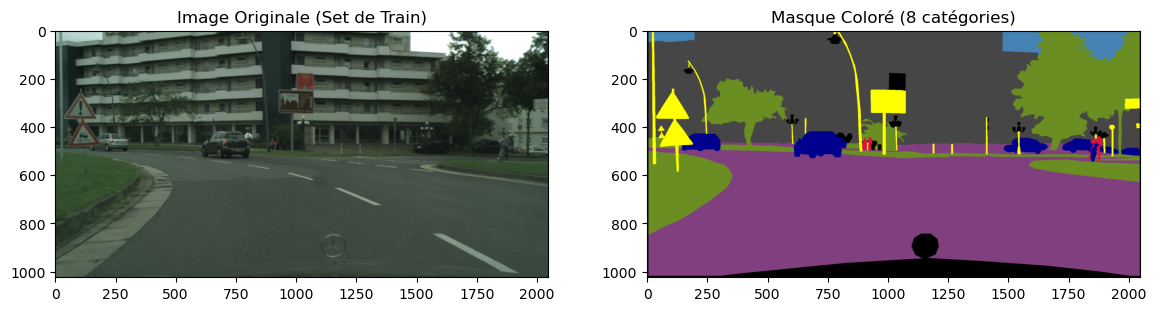

In [4]:
first_image_file = image_files_train[0]
first_label_file = label_files_train[0]
first_image = Image.open(first_image_file)
first_label = Image.open(first_label_file)
first_image_data = np.array(first_image)
first_label_data = np.array(first_label)

# Création du masque coloré pour se rendre compte des labels
palette = {
    0: [0, 0, 0],         # void - noir
    1: [128, 64, 128],    # flat - mauve
    2: [70, 70, 70],      # construction - gris
    3: [255, 255, 0],     # object - jaune
    4: [107, 142, 35],    # nature - vert olive
    5: [70, 130, 180],    # sky - bleu
    6: [220, 20, 60],     # human - rouge
    7: [0, 0, 142]        # vehicle - bleu foncé
}


def create_color_mask(label_data, palette):
    color_mask = np.zeros(
        (label_data.shape[0], label_data.shape[1], 3), dtype=np.uint8)
    for label, color in palette.items():
        color_mask[label_data == label] = color
    return color_mask


first_mask_data = create_color_mask(first_label_data, palette)
unique_labels = np.unique(first_label_data)
print("Unique label IDs (8 catégories):", unique_labels)
unique_colors = np.unique(
    first_mask_data.reshape(-1, first_mask_data.shape[2]), axis=0)
num_unique_colors = unique_colors.shape[0]
print("Nombre de couleurs uniques dans le masque coloré:", num_unique_colors)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.title("Image Originale (Set de Train)")
plt.imshow(first_image_data)
plt.subplot(1, 2, 2)
plt.title("Masque Coloré (8 catégories)")
plt.imshow(first_mask_data)
plt.show()

# 3. Le générateur de données

Nous allons préparer un générateur de données sous forme de classe Python "DataGenerator" afin qu'il fasse les tâches suivantes automatiquement :

- Chargement des images et des labels en lots (améliore la vitesse et l'efficacité de l'entraînement)
- Redimensionnement des images et normalisation (afin que les images soient compatibles aux neurones d'entrées du modèle)
- Conversion des labels en format one-hot pour la classification

Notre classe utilisera tf.data.Dataset pour la gestion des données :

- tf.data.Dataset est une API puissante et flexible de TensorFlow pour construire des pipelines de traitement de données. Elle permet de charger, prétraiter, et gérer efficacement de grands ensembles de données.
- Utilisation de tf.data.Dataset avec num_parallel_calls=tf.data.AUTOTUNE va permettre de paralléliser le chargement et le prétraitement des données, utilisant ainsi plusieurs cœurs de calcul.
- Utilisation de fonction intégrées à tf.dataset pour faire de la data augmentation: flip, ajustement de la luminosité et du contraste. L'argument augment (False/True) permet de contrôler si l'augmentation des données est appliquée ou non.

In [5]:
class DataGenerator:
    def __init__(self, image_files, label_files, batch_size=32, image_size=(256, 256), n_classes=8, augment=False):
        self.image_files = image_files
        self.label_files = label_files
        self.batch_size = batch_size
        self.image_size = image_size
        self.n_classes = n_classes
        self.augment = augment

    def load_and_preprocess_image(self, image_path, label_path):
        image = img_to_array(load_img(image_path, target_size=self.image_size)) / 255.0
        mask = np.array(load_img(label_path, target_size=self.image_size, color_mode="grayscale"))
        mask = np.eye(self.n_classes)[mask]
        return image.astype('float32'), mask.astype('float32')

    def augment_image(self, image, mask):
        # Random flip left/right
        combined = tf.concat([image, mask], axis=-1)
        combined = tf.image.random_flip_left_right(combined)
        image, mask = combined[..., :3], combined[..., 3:]
        # Adjust brightness slightly
        image = tf.image.random_brightness(image, max_delta=0.05)
        # Slight random contrast adjustment
        image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
        return image, mask

    def create_dataset(self):
        dataset = tf.data.Dataset.from_tensor_slices((self.image_files, self.label_files))
        dataset = dataset.map(lambda img, lbl: tf.numpy_function(self.load_and_preprocess_image, [img, lbl], [tf.float32, tf.float32]), num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.map(lambda img, mask: (tf.ensure_shape(img, [self.image_size[0], self.image_size[1], 3]), 
                                                 tf.ensure_shape(mask, [self.image_size[0], self.image_size[1], self.n_classes])), 
                              num_parallel_calls=tf.data.AUTOTUNE)
        if self.augment:
            dataset = dataset.map(lambda img, mask: self.augment_image(img, mask), num_parallel_calls=tf.data.AUTOTUNE)
        dataset = dataset.batch(self.batch_size)
        dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
        return dataset

# 4. La métrique d'évaluation
Pour évaluer un modèle de segmentation sémantique nous avons le choix de deux métriques : Dice Coefficient et IoU:

- Dice Coefficient : Le Dice Coefficient est une métrique de similarité qui mesure le chevauchement entre deux ensembles. C'est une métrique couramment utilisée pour les tâches de segmentation d'images car elle est sensible aux petites régions segmentées. Dice Coefficient est souvent préféré car il est plus sensible aux déséquilibres de classe, notamment dans les images médicales. 
- IoU (Intersection over Union) : L'IoU, elle,  mesure le chevauchement entre les prédictions du modèle et la vérité terrain, offrant une évaluation robuste des performances du modèle. IoU est préféré dans la segmentation urbaine.

Pour ces deux métriques, le résultat est un chiffre en 0 et 1, avec 1 une prédiction parfaite et 0 aucune correspondance. Pour ce projet, nous prendrons IoU car il est largement utilisé dans la segmentation urbaine et offre une interprétation claire du chevauchement des segments.

In [6]:
def iou(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1, 2, 3])
    union = K.sum(y_true, axis=[1, 2, 3]) + \
        K.sum(y_pred, axis=[1, 2, 3]) - intersection
    return K.mean((intersection + 1e-6) / (union + 1e-6), axis=0)

# 5. Modélisation
## 5.1 Modèle simple : Unet_mini
U-net est un modèle de réseaux de neurones particulièrement adapté à la segmentation sémantique. Son architecture en forme de U est composée de 3 blocs : 
- L'encodeur: Ce bloc consiste en un assemblage de couches de convolution et de couches de max pooling permettant de capturer les caractéristiques d’une image et de réduire sa taille pour diminuer le nombre de paramètres du réseau.
- Le pont: Il relie l’encodeur et le réseau de décodeurs et complète le flux d’informations. Il se compose de deux couches de convolutions.
- Le décodeur : Il permet la localisation précise grâce à la convolution transposée et permet également de retrouver la taille initiale de l'image. Le bloc décodeur commence par un sur-échantillonnage (upsampling) de la carte des caractéristiques suivie d'une couche de convolution 2x2 transposée. Après, deux couches de convolutions 3x3 sont utilisées, où chaque convolution est suivie d’une fonction d’activation ReLU. La sortie du dernier décodeur passe par une couche de convolution 1x1 avec une fonction d'activation sigmoïde.


Un modèle U-Net Mini est la version simplifiée du modèle U-Net, adaptée aux ressources limitées ou à des tâches nécessitant moins de complexité. Nous utiliserons la fonction de loss = "Dice Loss" (couramment utilisée pour la segmentation d'image) et l'optimiser Adam.

In [7]:
def unet_mini(input_size=(256, 256, 3)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    pool1 = Dropout(0.5)(pool1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    pool3 = Dropout(0.5)(conv3)

    up4 = UpSampling2D(size=(2, 2))(pool3)
    merge4 = concatenate([conv2, up4], axis=3)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(merge4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(128, 3, activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)

    up5 = UpSampling2D(size=(2, 2))(conv4)
    merge5 = concatenate([conv1, up5], axis=3)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(merge5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(64, 3, activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(8, 1, activation='softmax')(conv5)  # 8 classes

    model = Model(inputs, conv5)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_loss, metrics=[iou])

    return model

Nous allons entrainer notre modèle sur 50 epochs. Nous essayerons différentes valeurs de learning rate pour observer l'impact sur les performances du modèle. L'IoU et le temps d'entrainement seront mesurés.

L'accuracy pour ce genre de segmentation n'est pas recommandé car c'est une mesure de la proportion de pixels correctement classifiés parmi tous les pixels. Or, dans le contexte de la segmentation d'images, l'accuracy peut être trompeuse car elle peut être fortement influencée par la classe majoritaire. Par exemple, si la majorité des pixels de l'image appartiennent à une seule classe (comme le fond), un modèle peut obtenir une haute précision simplement en classifiant tous les pixels comme appartenant à cette classe majoritaire. C'est pourquoi l'IoU est utilisée.
- IoU (Intersection over Union) :
L'IoU est une métrique qui mesure l'overlap entre la prédiction et la vérité terrain. Elle est calculée comme le ratio de l'intersection entre les prédictions et les vérités terrain sur leur union.
L'IoU est une mesure plus stricte et plus informative pour les tâches de segmentation car elle prend en compte à la fois les faux positifs et les faux négatifs. Une IoU plus faible peut indiquer que, même si la majorité des pixels sont correctement classifiés (bonne précision), il y a encore beaucoup de pixels mal classifiés en termes de forme et de localisation.

In [8]:
def dice_loss(y_true, y_pred):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + 1) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + 1)

### Unet_mini

In [9]:
def train_mini(learning_rate, image_files_train, label_files_train, image_files_val, label_files_val, image_files_test, label_files_test):
    batch_size = 16
    print(f"Training with learning rate: {learning_rate}")
    
    train_gen = DataGenerator(image_files_train, label_files_train, batch_size=batch_size).create_dataset()
    val_gen = DataGenerator(image_files_val, label_files_val, batch_size=batch_size).create_dataset()
    test_gen = DataGenerator(image_files_test, label_files_test, batch_size=batch_size).create_dataset()

    model = unet_mini()
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=dice_loss, metrics=[iou])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    checkpoint_dir = f"lr_{learning_rate}"
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.keras")
    model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    start_time = time.time()
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        verbose=1,
        callbacks=[model_checkpoint, reduce_lr]
    )
    end_time = time.time()

    with open(f'history_lr_{learning_rate}.pkl', 'wb') as f:
        pickle.dump(history.history, f)
        
    train_iou = history.history['iou'][-1]
    val_iou = history.history['val_iou'][-1]
    
    model.load_weights(checkpoint_path)
    
    loss, test_iou = model.evaluate(test_gen, verbose=1)
    
    print(f"Training Time for learning rate {learning_rate}: {end_time - start_time:.2f} seconds")
    print(f"Training IoU for learning rate {learning_rate}: {train_iou:.2f}")
    print(f"Val IoU for learning rate {learning_rate}: {val_iou:.2f}")
    print(f"Test IoU for learning rate {learning_rate}: {test_iou:.2f}")
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    model.save(f"mini_unet_LR_{learning_rate}.keras")
    shutil.rmtree(checkpoint_dir)
    
    # clear memory
    K.clear_session()
    gc.collect()

In [10]:
learning_rates = [1e-4, 1e-3, 1e-2]
for learning_rate in learning_rates:
    train_mini(learning_rate, image_files_train, label_files_train, image_files_val, label_files_val, image_files_test, label_files_test)

Training with learning rate: 0.0001
Epoch 1/50


I0000 00:00:1719865277.368969    2200 service.cc:145] XLA service 0x7f461c028ac0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719865277.369099    2200 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
I0000 00:00:1719865316.430764    2200 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 496ms/step - iou: 0.3923 - loss: 0.4585
Epoch 1: val_loss improved from inf to 0.61926, saving model to lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 141s 600ms/step - iou: 0.3930 - loss: 0.4578 - val_iou: 0.2382 - val_loss: 0.6193 - learning_rate: 1.0000e-04
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - iou: 0.5949 - loss: 0.2599
Epoch 2: val_loss improved from 0.61926 to 0.61459, saving model to lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 54s 346ms/step - iou: 0.5950 - loss: 0.2599 - val_iou: 0.2418 - val_loss: 0.6146 - learning_rate: 1.0000e-04
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - iou: 0.6473 - loss: 0.2192
Epoch 3: val_loss improved from 0.61459 to 0.58577, saving model to lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 54s 342ms/step - iou: 0.6474 - loss: 0.2191 - val_iou: 0.2644 - val_loss: 0.5858 - learning_rate: 1.0000e-04
Epoch 4/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - iou: 0.668

Epoch 23/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - iou: 0.7738 - loss: 0.1316
Epoch 23: val_loss improved from 0.18560 to 0.18326, saving model to lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 52s 331ms/step - iou: 0.7738 - loss: 0.1316 - val_iou: 0.7029 - val_loss: 0.1833 - learning_rate: 1.0000e-04
Epoch 24/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - iou: 0.7767 - loss: 0.1297
Epoch 24: val_loss did not improve from 0.18326
155/155 ━━━━━━━━━━━━━━━━━━━━ 50s 319ms/step - iou: 0.7767 - loss: 0.1297 - val_iou: 0.7012 - val_loss: 0.1844 - learning_rate: 1.0000e-04
Epoch 25/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - iou: 0.7793 - loss: 0.1280
Epoch 25: val_loss improved from 0.18326 to 0.18276, saving model to lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 51s 327ms/step - iou: 0.7793 - loss: 0.1280 - val_iou: 0.7040 - val_loss: 0.1828 - learning_rate: 1.0000e-04
Epoch 26/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - iou: 0.7812 - loss: 0.1268
Epoch 26: 

Epoch 46/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - iou: 0.8064 - loss: 0.1109
Epoch 46: val_loss improved from 0.15756 to 0.15543, saving model to lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 51s 328ms/step - iou: 0.8064 - loss: 0.1109 - val_iou: 0.7434 - val_loss: 0.1554 - learning_rate: 1.0000e-04
Epoch 47/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - iou: 0.8071 - loss: 0.1105
Epoch 47: val_loss improved from 0.15543 to 0.14966, saving model to lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 51s 326ms/step - iou: 0.8071 - loss: 0.1105 - val_iou: 0.7511 - val_loss: 0.1497 - learning_rate: 1.0000e-04
Epoch 48/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - iou: 0.8086 - loss: 0.1095
Epoch 48: val_loss did not improve from 0.14966
155/155 ━━━━━━━━━━━━━━━━━━━━ 50s 318ms/step - iou: 0.8086 - loss: 0.1095 - val_iou: 0.7456 - val_loss: 0.1539 - learning_rate: 1.0000e-04
Epoch 49/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - iou: 0.8086 - loss: 0.1095
Epoch 49: 

Epoch 41/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - iou: 0.8238 - loss: 0.1001
Epoch 41: val_loss improved from 0.13489 to 0.13380, saving model to lr_0.001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 54s 343ms/step - iou: 0.8238 - loss: 0.1001 - val_iou: 0.7763 - val_loss: 0.1338 - learning_rate: 2.5000e-04
Epoch 42/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - iou: 0.8247 - loss: 0.0996
Epoch 42: val_loss did not improve from 0.13380
155/155 ━━━━━━━━━━━━━━━━━━━━ 52s 335ms/step - iou: 0.8247 - loss: 0.0996 - val_iou: 0.7685 - val_loss: 0.1385 - learning_rate: 2.5000e-04
Epoch 43/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - iou: 0.8256 - loss: 0.0990
Epoch 43: val_loss did not improve from 0.13380
155/155 ━━━━━━━━━━━━━━━━━━━━ 52s 333ms/step - iou: 0.8256 - loss: 0.0990 - val_iou: 0.7720 - val_loss: 0.1363 - learning_rate: 2.5000e-04
Epoch 44/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - iou: 0.8259 - loss: 0.0989
Epoch 44: val_loss did not improve from 0.13380
155/155 ━━━

Epoch 36/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - iou: 0.8093 - loss: 0.1092
Epoch 36: val_loss improved from 0.14534 to 0.14179, saving model to lr_0.01/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 54s 344ms/step - iou: 0.8092 - loss: 0.1092 - val_iou: 0.7656 - val_loss: 0.1418 - learning_rate: 0.0025
Epoch 37/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - iou: 0.8098 - loss: 0.1088
Epoch 37: val_loss did not improve from 0.14179
155/155 ━━━━━━━━━━━━━━━━━━━━ 52s 335ms/step - iou: 0.8098 - loss: 0.1088 - val_iou: 0.7626 - val_loss: 0.1443 - learning_rate: 0.0025
Epoch 38/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - iou: 0.8110 - loss: 0.1081
Epoch 38: val_loss did not improve from 0.14179
155/155 ━━━━━━━━━━━━━━━━━━━━ 53s 337ms/step - iou: 0.8110 - loss: 0.1081 - val_iou: 0.7546 - val_loss: 0.1502 - learning_rate: 0.0025
Epoch 39/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - iou: 0.8117 - loss: 0.1077
Epoch 39: val_loss improved from 0.14179 to 0.14144, saving model to lr_

In [18]:
learning_rate_to_load = 1e-3
model_path = f"mini_unet_LR_{learning_rate_to_load}.keras"
model = load_model(model_path)

/home/titi/anaconda3/envs/gpu_env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:562: UserWarning: Skipping variable loading for optimizer 'adam', because it has 86 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


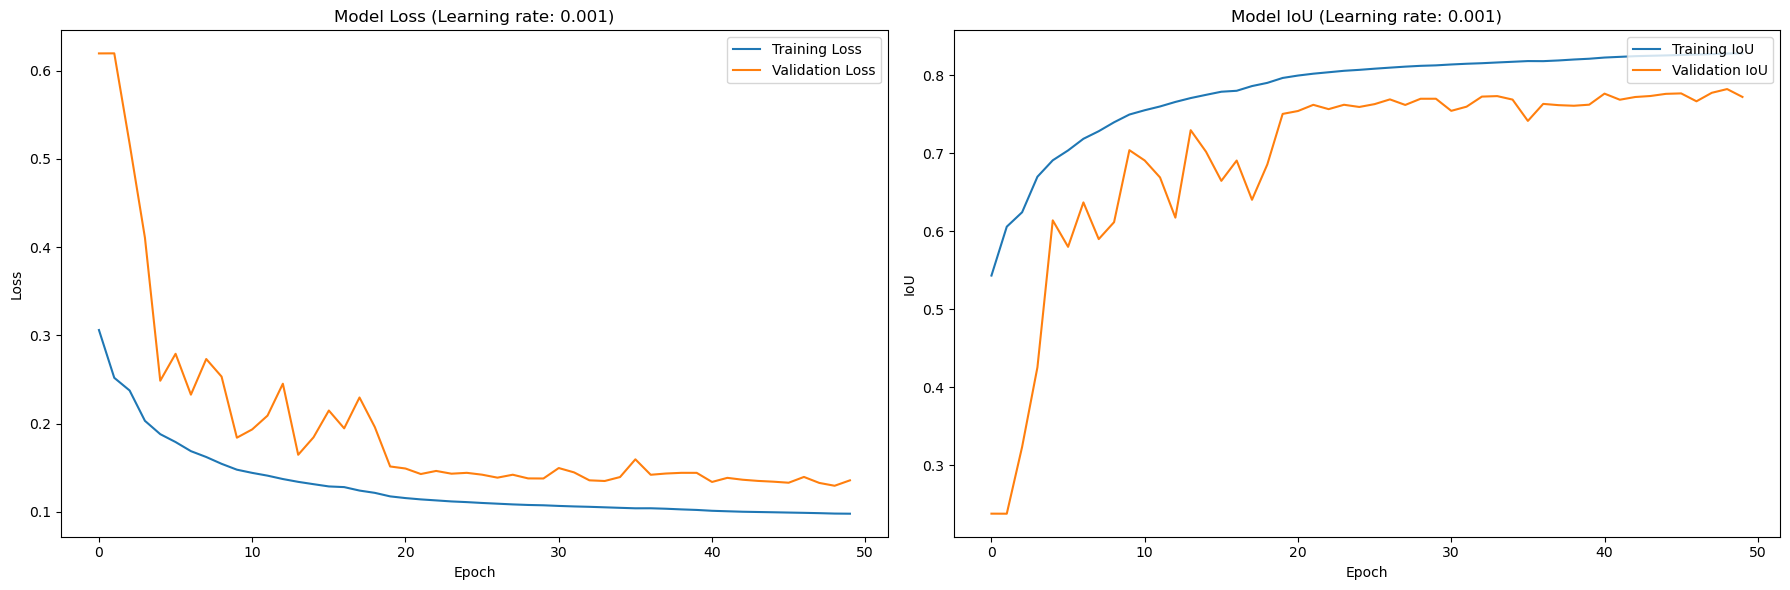

In [19]:
def plot_history(lr):
    history_path = f'history_lr_{lr}.pkl'
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # loss
    axes[0].plot(history['loss'], label='Training Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title(f'Model Loss (Learning rate: {lr})')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='upper right')

    # IoU
    axes[1].plot(history['iou'], label='Training IoU')
    axes[1].plot(history['val_iou'], label='Validation IoU')
    axes[1].set_title(f'Model IoU (Learning rate: {lr})')
    axes[1].set_ylabel('IoU')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')

    plt.tight_layout()
    plt.show()


plot_history(learning_rate_to_load)

### Unet_mini + data augmentation

In [11]:
def train_mini_aug(learning_rate, image_files_train, label_files_train, image_files_val, label_files_val, image_files_test, label_files_test):
    batch_size = 16
    print(f"Training with learning rate: {learning_rate}")
    
    train_gen = DataGenerator(image_files_train, label_files_train, batch_size=batch_size, augment=True).create_dataset()
    val_gen = DataGenerator(image_files_val, label_files_val, batch_size=batch_size).create_dataset()
    test_gen = DataGenerator(image_files_test, label_files_test, batch_size=batch_size).create_dataset()

    model = unet_mini()
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=dice_loss, metrics=[iou])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    checkpoint_dir = f"lr_{learning_rate}"
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.keras")
    model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    start_time = time.time()
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        verbose=1,
        callbacks=[model_checkpoint, reduce_lr]
    )
    end_time = time.time()

    with open(f'history_aug_lr_{learning_rate}.pkl', 'wb') as f:
        pickle.dump(history.history, f)
        
    train_iou = history.history['iou'][-1]
    val_iou = history.history['val_iou'][-1]
    
    model.load_weights(checkpoint_path)
    
    loss, test_iou = model.evaluate(test_gen, verbose=1)
    
    print(f"Training Time for learning rate {learning_rate}: {end_time - start_time:.2f} seconds")
    print(f"Training IoU for learning rate {learning_rate}: {train_iou:.2f}")
    print(f"Val IoU for learning rate {learning_rate}: {val_iou:.2f}")
    print(f"Test IoU for learning rate {learning_rate}: {test_iou:.2f}")
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    model.save(f"mini_unet_aug_LR_{learning_rate}.keras")
    shutil.rmtree(checkpoint_dir)
    
    # clear memory
    K.clear_session()
    gc.collect()

In [12]:
learning_rates = [1e-4, 1e-3, 1e-2]
for learning_rate in learning_rates:
    train_mini_aug(learning_rate, image_files_train, label_files_train, image_files_val, label_files_val, image_files_test, label_files_test)

Training with learning rate: 0.0001
Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - iou: 0.3838 - loss: 0.4647
Epoch 1: val_loss improved from inf to 0.63581, saving model to lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 82s 408ms/step - iou: 0.3844 - loss: 0.4641 - val_iou: 0.2253 - val_loss: 0.6358 - learning_rate: 1.0000e-04
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - iou: 0.5952 - loss: 0.2600
Epoch 2: val_loss improved from 0.63581 to 0.60183, saving model to lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 54s 344ms/step - iou: 0.5952 - loss: 0.2600 - val_iou: 0.2516 - val_loss: 0.6018 - learning_rate: 1.0000e-04
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - iou: 0.6324 - loss: 0.2306
Epoch 3: val_loss improved from 0.60183 to 0.57029, saving model to lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 55s 348ms/step - iou: 0.6324 - loss: 0.2306 - val_iou: 0.2769 - val_loss: 0.5703 - learning_rate: 1.0000e-04
Epoch 4/50
155/155 ━

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - iou: 0.8009 - loss: 0.1143
Epoch 46: val_loss improved from 0.16699 to 0.16609, saving model to lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 54s 348ms/step - iou: 0.8009 - loss: 0.1143 - val_iou: 0.7259 - val_loss: 0.1661 - learning_rate: 5.0000e-05
Epoch 47/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - iou: 0.8022 - loss: 0.1135
Epoch 47: val_loss did not improve from 0.16609
155/155 ━━━━━━━━━━━━━━━━━━━━ 54s 346ms/step - iou: 0.8022 - loss: 0.1135 - val_iou: 0.7213 - val_loss: 0.1692 - learning_rate: 5.0000e-05
Epoch 48/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - iou: 0.8026 - loss: 0.1133
Epoch 48: val_loss improved from 0.16609 to 0.16601, saving model to lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 55s 353ms/step - iou: 0.8025 - loss: 0.1133 - val_iou: 0.7261 - val_loss: 0.1660 - learning_rate: 5.0000e-05
Epoch 49/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - iou: 0.8034 - loss: 0.1127
Epoch 49: val_loss did

155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - iou: 0.8267 - loss: 0.0984
Epoch 41: val_loss did not improve from 0.12500

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
155/155 ━━━━━━━━━━━━━━━━━━━━ 53s 342ms/step - iou: 0.8267 - loss: 0.0984 - val_iou: 0.7845 - val_loss: 0.1286 - learning_rate: 5.0000e-04
Epoch 42/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - iou: 0.8272 - loss: 0.0981
Epoch 42: val_loss improved from 0.12500 to 0.12182, saving model to lr_0.001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 54s 349ms/step - iou: 0.8272 - loss: 0.0981 - val_iou: 0.7936 - val_loss: 0.1218 - learning_rate: 2.5000e-04
Epoch 43/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - iou: 0.8291 - loss: 0.0969
Epoch 43: val_loss did not improve from 0.12182
155/155 ━━━━━━━━━━━━━━━━━━━━ 53s 340ms/step - iou: 0.8291 - loss: 0.0969 - val_iou: 0.7899 - val_loss: 0.1247 - learning_rate: 2.5000e-04
Epoch 44/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - iou: 0.8300 - loss: 

Epoch 13/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - iou: 0.7417 - loss: 0.1527
Epoch 13: val_loss did not improve from 0.19522
155/155 ━━━━━━━━━━━━━━━━━━━━ 53s 335ms/step - iou: 0.7417 - loss: 0.1527 - val_iou: 0.6679 - val_loss: 0.2121 - learning_rate: 0.0100
Epoch 14/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - iou: 0.7413 - loss: 0.1531
Epoch 14: val_loss did not improve from 0.19522
155/155 ━━━━━━━━━━━━━━━━━━━━ 53s 338ms/step - iou: 0.7413 - loss: 0.1531 - val_iou: 0.6637 - val_loss: 0.2108 - learning_rate: 0.0100
Epoch 15/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step - iou: 0.7528 - loss: 0.1453
Epoch 15: val_loss did not improve from 0.19522
155/155 ━━━━━━━━━━━━━━━━━━━━ 53s 341ms/step - iou: 0.7528 - loss: 0.1453 - val_iou: 0.6294 - val_loss: 0.2380 - learning_rate: 0.0100
Epoch 16/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - iou: 0.7542 - loss: 0.1443
Epoch 16: val_loss did not improve from 0.19522
155/155 ━━━━━━━━━━━━━━━━━━━━ 53s 338ms/step - iou: 0.7542 - loss: 0.14

Epoch 36/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - iou: 0.8050 - loss: 0.1118
Epoch 36: val_loss did not improve from 0.13936
155/155 ━━━━━━━━━━━━━━━━━━━━ 53s 338ms/step - iou: 0.8049 - loss: 0.1118 - val_iou: 0.7631 - val_loss: 0.1420 - learning_rate: 0.0025
Epoch 37/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - iou: 0.8059 - loss: 0.1112
Epoch 37: val_loss improved from 0.13936 to 0.13796, saving model to lr_0.01/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 54s 344ms/step - iou: 0.8059 - loss: 0.1112 - val_iou: 0.7698 - val_loss: 0.1380 - learning_rate: 0.0025
Epoch 38/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - iou: 0.8076 - loss: 0.1101
Epoch 38: val_loss did not improve from 0.13796
155/155 ━━━━━━━━━━━━━━━━━━━━ 53s 339ms/step - iou: 0.8076 - loss: 0.1102 - val_iou: 0.7667 - val_loss: 0.1406 - learning_rate: 0.0025
Epoch 39/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - iou: 0.8081 - loss: 0.1098
Epoch 39: val_loss did not improve from 0.13796
155/155 ━━━━━━━━━━━━━━━━

In [20]:
learning_rate_to_load = 1e-3
model_path = f"mini_unet_aug_LR_{learning_rate_to_load}.keras"
model = load_model(model_path)

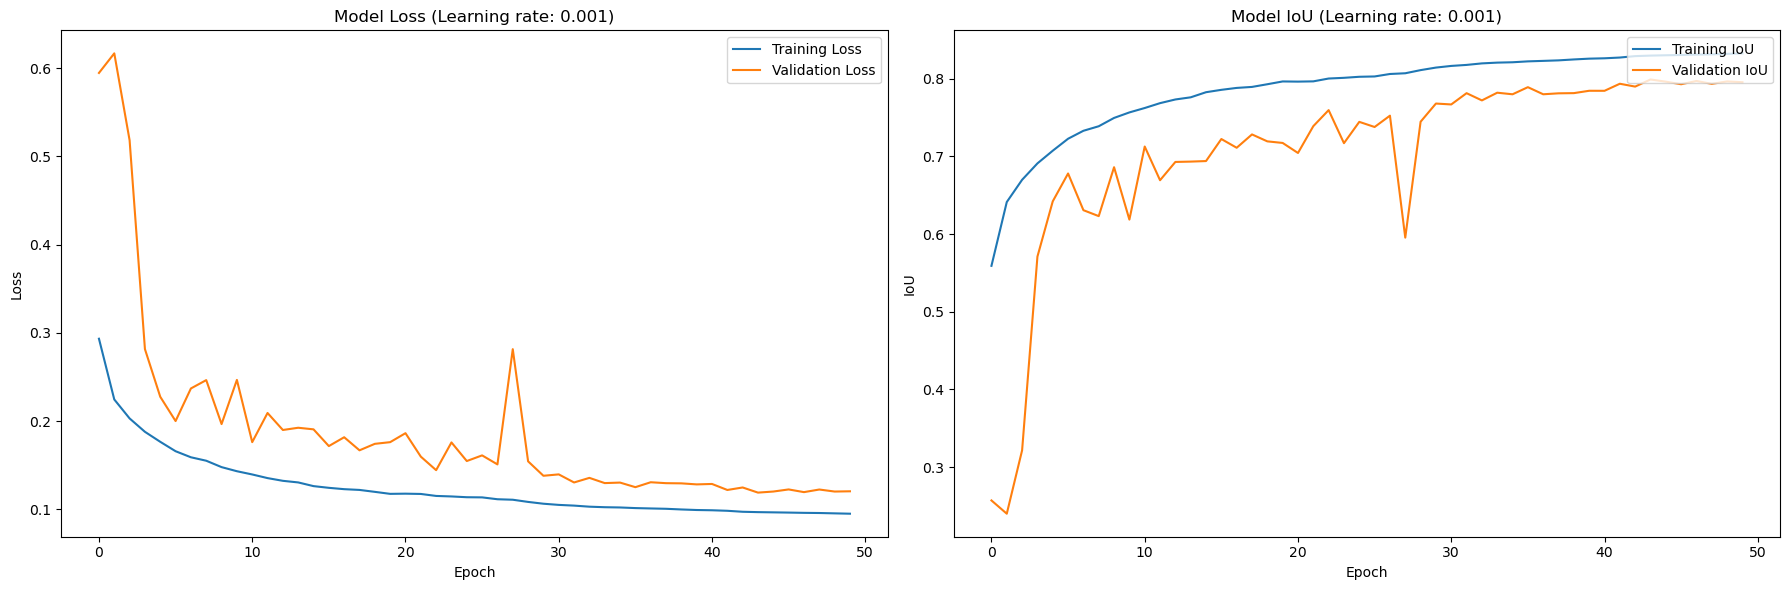

In [21]:
def plot_history_aug(lr):
    history_path = f'history_aug_lr_{lr}.pkl'
    with open(history_path, 'rb') as f:
        history = pickle.load(f)
    fig, axes = plt.subplots(1, 2, figsize=(18, 6))

    # loss
    axes[0].plot(history['loss'], label='Training Loss')
    axes[0].plot(history['val_loss'], label='Validation Loss')
    axes[0].set_title(f'Model Loss (Learning rate: {lr})')
    axes[0].set_ylabel('Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].legend(loc='upper right')

    # IoU
    axes[1].plot(history['iou'], label='Training IoU')
    axes[1].plot(history['val_iou'], label='Validation IoU')
    axes[1].set_title(f'Model IoU (Learning rate: {lr})')
    axes[1].set_ylabel('IoU')
    axes[1].set_xlabel('Epoch')
    axes[1].legend(loc='upper right')

    plt.tight_layout()
    plt.show()
    
plot_history_aug(learning_rate_to_load)

## 5.2 Modèle avancé : VGG16-Unet
Le modèle VGG16 U-Net combine les caractéristiques des réseaux convolutifs VGG16 et de la structure U-Net. Le VGG16 est un réseau de neurones convolutifs (CNN) préentraîné, réputé pour ses performances sur la tâche de classification d'images. Le VGG16 U-Net utilise les couches convolutives du VGG16 comme encodeur pour extraire des caractéristiques, puis les couches de décodeur typiques de U-Net pour obtenir des prédictions de segmentation avec une résolution élevée.

In [13]:
def vgg16_unet(input_size=(256, 256, 3), n_classes=8):
    inputs = Input(input_size)
    vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=inputs)

    # Encoder
    block1_conv2 = vgg16.get_layer('block1_conv2').output
    block2_conv2 = vgg16.get_layer('block2_conv2').output
    block3_conv3 = vgg16.get_layer('block3_conv3').output
    block4_conv3 = vgg16.get_layer('block4_conv3').output
    block5_conv3 = vgg16.get_layer('block5_conv3').output

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(block5_conv3)
    up6 = concatenate([up6, block4_conv3], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, block3_conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, block2_conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = BatchNormalization()(conv8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)
    conv8 = BatchNormalization()(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, block1_conv2], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = BatchNormalization()(conv9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = BatchNormalization()(conv9)

    conv10 = Conv2D(n_classes, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=conv10)

    return model

### VGG16-Unet

In [14]:
def train_vgg16_unet(learning_rate, image_files_train, label_files_train, image_files_val, label_files_val, image_files_test, label_files_test):
    batch_size = 16
    print(f"Training with learning rate: {learning_rate}")
    
    train_gen = DataGenerator(image_files_train, label_files_train, batch_size=batch_size).create_dataset()
    val_gen = DataGenerator(image_files_val, label_files_val, batch_size=batch_size).create_dataset()
    test_gen = DataGenerator(image_files_test, label_files_test, batch_size=batch_size).create_dataset()

    model = vgg16_unet()
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=dice_loss, metrics=[iou])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    checkpoint_dir = f"vgg16_lr_{learning_rate}"
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.keras")
    model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    start_time = time.time()
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        verbose=1,
        callbacks=[model_checkpoint, reduce_lr]
    )
    end_time = time.time()

    with open(f'history_vgg16_lr_{learning_rate}.pkl', 'wb') as f:
        pickle.dump(history.history, f)
        
    train_iou = history.history['iou'][-1]
    val_iou = history.history['val_iou'][-1]
    
    model.load_weights(checkpoint_path)
    
    loss, test_iou = model.evaluate(test_gen, verbose=1)
    
    print(f"Training Time for learning rate {learning_rate}: {end_time - start_time:.2f} seconds")
    print(f"Training IoU for learning rate {learning_rate}: {train_iou:.2f}")
    print(f"Val IoU for learning rate {learning_rate}: {val_iou:.2f}")
    print(f"Test IoU for learning rate {learning_rate}: {test_iou:.2f}")
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    model.save(f"vgg16_unet_LR_{learning_rate}.keras")
    shutil.rmtree(checkpoint_dir)
    
    # clear memory
    K.clear_session()
    gc.collect()

In [15]:
learning_rates = [1e-4, 1e-3, 1e-2]
for learning_rate in learning_rates:
    train_vgg16_unet(learning_rate, image_files_train, label_files_train, image_files_val, label_files_val, image_files_test, label_files_test)

Training with learning rate: 0.0001
Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step - iou: 0.5208 - loss: 0.3482
Epoch 1: val_loss improved from inf to 0.20484, saving model to vgg16_lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 107s 533ms/step - iou: 0.5216 - loss: 0.3474 - val_iou: 0.6714 - val_loss: 0.2048 - learning_rate: 1.0000e-04
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - iou: 0.7489 - loss: 0.1479
Epoch 2: val_loss improved from 0.20484 to 0.15912, saving model to vgg16_lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 68s 434ms/step - iou: 0.7490 - loss: 0.1479 - val_iou: 0.7373 - val_loss: 0.1591 - learning_rate: 1.0000e-04
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - iou: 0.7761 - loss: 0.1302
Epoch 3: val_loss improved from 0.15912 to 0.13998, saving model to vgg16_lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 68s 435ms/step - iou: 0.7761 - loss: 0.1302 - val_iou: 0.7656 - val_loss: 0.1400 - learning_rate: 1.0000e-04
E

Epoch 46/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - iou: 0.9292 - loss: 0.0374
Epoch 46: val_loss did not improve from 0.09146
155/155 ━━━━━━━━━━━━━━━━━━━━ 53s 339ms/step - iou: 0.9292 - loss: 0.0373 - val_iou: 0.8383 - val_loss: 0.0927 - learning_rate: 1.2500e-05
Epoch 47/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - iou: 0.9302 - loss: 0.0368
Epoch 47: val_loss did not improve from 0.09146

Epoch 47: ReduceLROnPlateau reducing learning rate to 6.24999984211172e-06.
155/155 ━━━━━━━━━━━━━━━━━━━━ 53s 337ms/step - iou: 0.9302 - loss: 0.0368 - val_iou: 0.8369 - val_loss: 0.0934 - learning_rate: 1.2500e-05
Epoch 48/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - iou: 0.9299 - loss: 0.0370
Epoch 48: val_loss did not improve from 0.09146
155/155 ━━━━━━━━━━━━━━━━━━━━ 53s 340ms/step - iou: 0.9299 - loss: 0.0370 - val_iou: 0.8383 - val_loss: 0.0927 - learning_rate: 6.2500e-06
Epoch 49/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - iou: 0.9306 - loss: 0.0366
Epoch 49: val_loss did not im

Epoch 41/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - iou: 0.8583 - loss: 0.0793
Epoch 41: val_loss improved from 0.10953 to 0.10918, saving model to vgg16_lr_0.001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 68s 430ms/step - iou: 0.8583 - loss: 0.0793 - val_iou: 0.8139 - val_loss: 0.1092 - learning_rate: 5.0000e-04
Epoch 42/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - iou: 0.8591 - loss: 0.0788
Epoch 42: val_loss improved from 0.10918 to 0.10912, saving model to vgg16_lr_0.001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 69s 440ms/step - iou: 0.8591 - loss: 0.0788 - val_iou: 0.8141 - val_loss: 0.1091 - learning_rate: 5.0000e-04
Epoch 43/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - iou: 0.8621 - loss: 0.0770
Epoch 43: val_loss improved from 0.10912 to 0.10810, saving model to vgg16_lr_0.001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 67s 426ms/step - iou: 0.8621 - loss: 0.0770 - val_iou: 0.8159 - val_loss: 0.1081 - learning_rate: 5.0000e-04
Epoch 44/50
155/155 ━━━━━━━━━━━

Epoch 13/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - iou: 0.6601 - loss: 0.2103
Epoch 13: val_loss improved from 0.32611 to 0.25180, saving model to vgg16_lr_0.01/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 68s 435ms/step - iou: 0.6601 - loss: 0.2103 - val_iou: 0.6096 - val_loss: 0.2518 - learning_rate: 0.0050
Epoch 14/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - iou: 0.6641 - loss: 0.2073
Epoch 14: val_loss improved from 0.25180 to 0.25030, saving model to vgg16_lr_0.01/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 69s 436ms/step - iou: 0.6641 - loss: 0.2073 - val_iou: 0.6120 - val_loss: 0.2503 - learning_rate: 0.0050
Epoch 15/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - iou: 0.6683 - loss: 0.2043
Epoch 15: val_loss improved from 0.25030 to 0.23759, saving model to vgg16_lr_0.01/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 68s 433ms/step - iou: 0.6683 - loss: 0.2043 - val_iou: 0.6282 - val_loss: 0.2376 - learning_rate: 0.0050
Epoch 16/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 27

Epoch 36/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - iou: 0.7824 - loss: 0.1261
Epoch 36: val_loss did not improve from 0.16439
155/155 ━━━━━━━━━━━━━━━━━━━━ 51s 330ms/step - iou: 0.7824 - loss: 0.1261 - val_iou: 0.5252 - val_loss: 0.3194 - learning_rate: 0.0050
Epoch 37/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - iou: 0.7830 - loss: 0.1257
Epoch 37: val_loss did not improve from 0.16439
155/155 ━━━━━━━━━━━━━━━━━━━━ 52s 336ms/step - iou: 0.7830 - loss: 0.1257 - val_iou: 0.6689 - val_loss: 0.2050 - learning_rate: 0.0050
Epoch 38/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - iou: 0.7827 - loss: 0.1259
Epoch 38: val_loss improved from 0.16439 to 0.16351, saving model to vgg16_lr_0.01/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 68s 434ms/step - iou: 0.7826 - loss: 0.1259 - val_iou: 0.7312 - val_loss: 0.1635 - learning_rate: 0.0050
Epoch 39/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - iou: 0.7832 - loss: 0.1256
Epoch 39: val_loss improved from 0.16351 to 0.15921, saving model 

/home/titi/anaconda3/envs/gpu_env/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:562: UserWarning: Skipping variable loading for optimizer 'adam', because it has 122 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


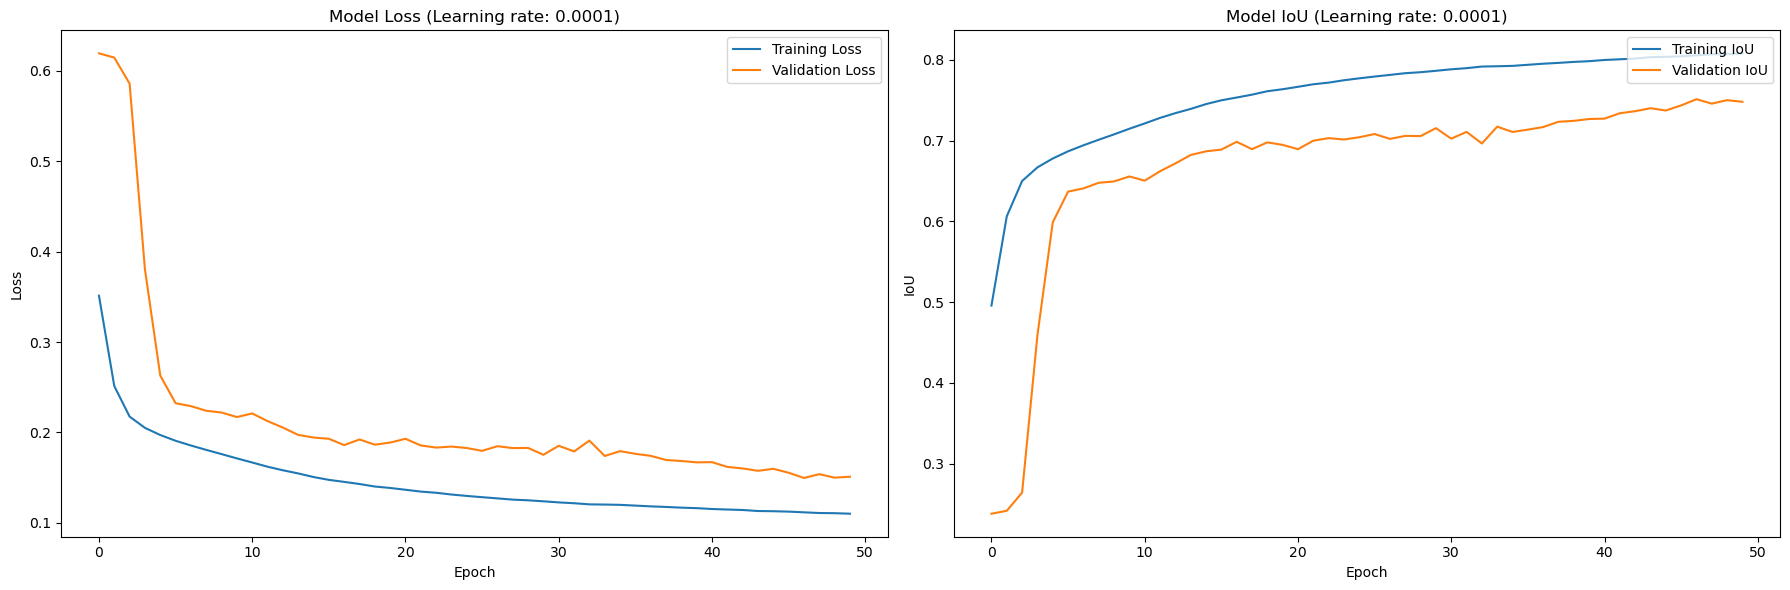

In [22]:
learning_rate_to_load = 1e-4
model_path = f"vgg16_unet_LR_{learning_rate_to_load}.keras"
model = load_model(model_path)
plot_history(learning_rate_to_load)

### VGG16-Unet + data augmentation

In [16]:
def train_vgg16_unet_aug(learning_rate, image_files_train, label_files_train, image_files_val, label_files_val, image_files_test, label_files_test):
    batch_size = 16
    print(f"Training with learning rate: {learning_rate}")
    
    train_gen = DataGenerator(image_files_train, label_files_train, batch_size=batch_size, augment=True).create_dataset()
    val_gen = DataGenerator(image_files_val, label_files_val, batch_size=batch_size).create_dataset()
    test_gen = DataGenerator(image_files_test, label_files_test, batch_size=batch_size).create_dataset()

    model = vgg16_unet()
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss=dice_loss, metrics=[iou])

    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
    checkpoint_dir = f"vgg16_lr_{learning_rate}"
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    checkpoint_path = os.path.join(checkpoint_dir, "checkpoint.keras")
    model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    start_time = time.time()
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        verbose=1,
        callbacks=[model_checkpoint, reduce_lr]
    )
    end_time = time.time()

    with open(f'history_vgg16_aug_lr_{learning_rate}.pkl', 'wb') as f:
        pickle.dump(history.history, f)
        
    train_iou = history.history['iou'][-1]
    val_iou = history.history['val_iou'][-1]
    
    model.load_weights(checkpoint_path)
    
    loss, test_iou = model.evaluate(test_gen, verbose=1)
    
    print(f"Training Time for learning rate {learning_rate}: {end_time - start_time:.2f} seconds")
    print(f"Training IoU for learning rate {learning_rate}: {train_iou:.2f}")
    print(f"Val IoU for learning rate {learning_rate}: {val_iou:.2f}")
    print(f"Test IoU for learning rate {learning_rate}: {test_iou:.2f}")
    
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])
    model.save(f"vgg16_unet_aug_LR_{learning_rate}.keras")
    shutil.rmtree(checkpoint_dir)
    
    # clear memory
    K.clear_session()
    gc.collect()

In [17]:
learning_rates = [1e-4, 1e-3, 1e-2]
for learning_rate in learning_rates:
    train_vgg16_unet_aug(learning_rate, image_files_train, label_files_train, image_files_val, label_files_val, image_files_test, label_files_test)

Training with learning rate: 0.0001
Epoch 1/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - iou: 0.5177 - loss: 0.3440
Epoch 1: val_loss improved from inf to 0.20290, saving model to vgg16_lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 92s 484ms/step - iou: 0.5185 - loss: 0.3432 - val_iou: 0.6749 - val_loss: 0.2029 - learning_rate: 1.0000e-04
Epoch 2/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - iou: 0.7428 - loss: 0.1520
Epoch 2: val_loss improved from 0.20290 to 0.16442, saving model to vgg16_lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 69s 438ms/step - iou: 0.7429 - loss: 0.1519 - val_iou: 0.7305 - val_loss: 0.1644 - learning_rate: 1.0000e-04
Epoch 3/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - iou: 0.7752 - loss: 0.1306
Epoch 3: val_loss improved from 0.16442 to 0.15764, saving model to vgg16_lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 70s 447ms/step - iou: 0.7753 - loss: 0.1306 - val_iou: 0.7401 - val_loss: 0.1576 - learning_rate: 1.0000e-04
Ep

Epoch 23/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - iou: 0.8750 - loss: 0.0688
Epoch 23: val_loss improved from 0.09499 to 0.09473, saving model to vgg16_lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 69s 441ms/step - iou: 0.8750 - loss: 0.0688 - val_iou: 0.8360 - val_loss: 0.0947 - learning_rate: 1.0000e-04
Epoch 24/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - iou: 0.8783 - loss: 0.0669
Epoch 24: val_loss improved from 0.09473 to 0.09098, saving model to vgg16_lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 70s 446ms/step - iou: 0.8783 - loss: 0.0669 - val_iou: 0.8422 - val_loss: 0.0910 - learning_rate: 1.0000e-04
Epoch 25/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - iou: 0.8806 - loss: 0.0655
Epoch 25: val_loss did not improve from 0.09098
155/155 ━━━━━━━━━━━━━━━━━━━━ 53s 337ms/step - iou: 0.8806 - loss: 0.0655 - val_iou: 0.8386 - val_loss: 0.0931 - learning_rate: 1.0000e-04
Epoch 26/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - iou: 0.8762 - loss: 0.068

155/155 ━━━━━━━━━━━━━━━━━━━━ 53s 335ms/step - iou: 0.9086 - loss: 0.0494 - val_iou: 0.8495 - val_loss: 0.0866 - learning_rate: 5.0000e-05
Epoch 46/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - iou: 0.9099 - loss: 0.0486
Epoch 46: val_loss did not improve from 0.08605
155/155 ━━━━━━━━━━━━━━━━━━━━ 53s 341ms/step - iou: 0.9100 - loss: 0.0486 - val_iou: 0.8499 - val_loss: 0.0864 - learning_rate: 5.0000e-05
Epoch 47/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - iou: 0.9117 - loss: 0.0476
Epoch 47: val_loss improved from 0.08605 to 0.08600, saving model to vgg16_lr_0.0001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 67s 429ms/step - iou: 0.9117 - loss: 0.0476 - val_iou: 0.8504 - val_loss: 0.0860 - learning_rate: 5.0000e-05
Epoch 48/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - iou: 0.9130 - loss: 0.0469
Epoch 48: val_loss did not improve from 0.08600
155/155 ━━━━━━━━━━━━━━━━━━━━ 53s 341ms/step - iou: 0.9130 - loss: 0.0469 - val_iou: 0.8492 - val_loss: 0.0867 - learning_rate: 5.0000e-0

Epoch 40/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - iou: 0.8556 - loss: 0.0810
Epoch 40: val_loss did not improve from 0.10644
155/155 ━━━━━━━━━━━━━━━━━━━━ 54s 341ms/step - iou: 0.8556 - loss: 0.0810 - val_iou: 0.8109 - val_loss: 0.1114 - learning_rate: 0.0010
Epoch 41/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - iou: 0.8564 - loss: 0.0805
Epoch 41: val_loss did not improve from 0.10644
155/155 ━━━━━━━━━━━━━━━━━━━━ 54s 344ms/step - iou: 0.8564 - loss: 0.0805 - val_iou: 0.8080 - val_loss: 0.1137 - learning_rate: 0.0010
Epoch 42/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - iou: 0.8550 - loss: 0.0813
Epoch 42: val_loss improved from 0.10644 to 0.10558, saving model to vgg16_lr_0.001/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 69s 446ms/step - iou: 0.8550 - loss: 0.0813 - val_iou: 0.8191 - val_loss: 0.1056 - learning_rate: 0.0010
Epoch 43/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - iou: 0.8577 - loss: 0.0797
Epoch 43: val_loss did not improve from 0.10558
155/155 ━━━━━━━━━

Epoch 35/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - iou: 0.5701 - loss: 0.2849
Epoch 35: val_loss did not improve from 0.31993

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0006249999860301614.
155/155 ━━━━━━━━━━━━━━━━━━━━ 54s 347ms/step - iou: 0.5701 - loss: 0.2849 - val_iou: 0.5235 - val_loss: 0.3213 - learning_rate: 0.0012
Epoch 36/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - iou: 0.5702 - loss: 0.2848
Epoch 36: val_loss improved from 0.31993 to 0.31108, saving model to vgg16_lr_0.01/checkpoint.keras
155/155 ━━━━━━━━━━━━━━━━━━━━ 69s 444ms/step - iou: 0.5702 - loss: 0.2848 - val_iou: 0.5361 - val_loss: 0.3111 - learning_rate: 6.2500e-04
Epoch 37/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - iou: 0.5713 - loss: 0.2839
Epoch 37: val_loss did not improve from 0.31108
155/155 ━━━━━━━━━━━━━━━━━━━━ 54s 343ms/step - iou: 0.5713 - loss: 0.2839 - val_iou: 0.5336 - val_loss: 0.3132 - learning_rate: 6.2500e-04
Epoch 38/50
155/155 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - iou: 0.

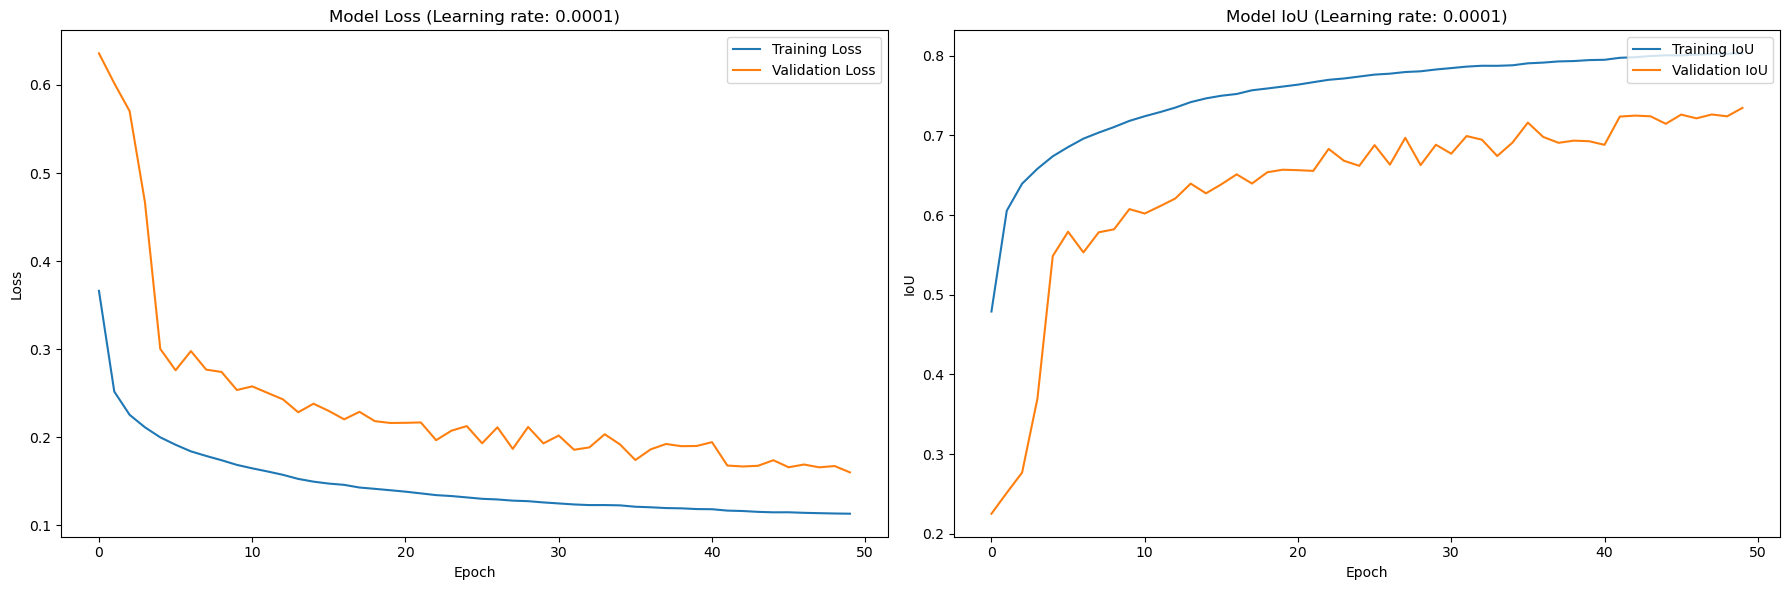

In [23]:
learning_rate_to_load = 1e-4
model_path = f"vgg16_unet_aug_LR_{learning_rate_to_load}.keras"
model = load_model(model_path)
plot_history_aug(learning_rate_to_load)

C'est vgg16 + data augmentation à un learning rate de 1e-4 qui offre les meilleurs performances de test (IoU = 0.87). Nous allons utiliser celui-ci pour le déploiement.

In [20]:
learning_rate_to_load = 1e-4
model_path = f"vgg16_unet_LR_{learning_rate_to_load}.keras"
model = tf.keras.models.load_model(model_path)
model.save('model.keras')

# 6. Inférence
Testons notre modèle avec le dossier test_mg8bit comprenant des images non utilisées.

In [23]:
model = tf.keras.models.load_model('model.keras')

In [39]:
test_image_dir = 'data/test_mg8bit'
test_image_files = [f for f in os.listdir(test_image_dir) if f.endswith('leftImg8bit.png')]
test_image_path = os.path.join(test_image_dir, random.choice(test_image_files))

original_image = Image.open(test_image_path)
original_size = original_image.size
image = original_image.resize((256, 256))
input_array = img_to_array(image) / 255.0
input_array = np.expand_dims(input_array, axis=0)

In [40]:
predicted_mask = model.predict(input_array)[0]
predicted_mask = np.argmax(predicted_mask, axis=-1)
predicted_mask_resized = Image.fromarray(predicted_mask.astype(np.uint8)).resize(original_size, Image.NEAREST)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


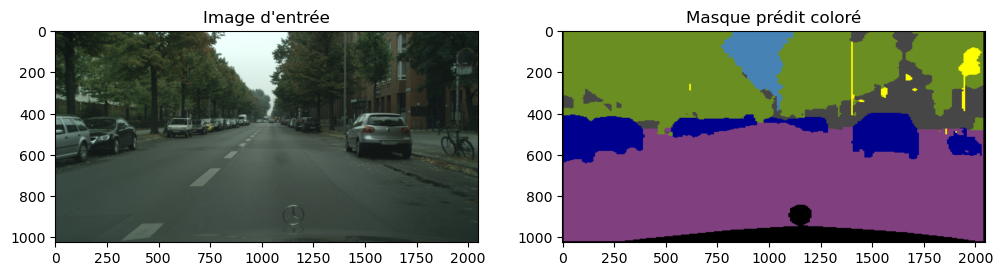

In [41]:
def color_mask(mask, palette):
    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for label, color in palette.items():
        color_mask[mask == label] = color
    return color_mask

colored_mask = color_mask(np.array(predicted_mask_resized), palette)
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_image)
plt.title('Image d\'entrée')


plt.subplot(1, 2, 2)
plt.imshow(colored_mask)
plt.title('Masque prédit coloré')


plt.show()

La délimitation des différents objets détectés n'est pas aussi précise que celles des masques d'entrainement, cependant le modèle a bien classé les arbres, les différents véhicules, les batiments et les objets, ce qui est plutôt prometteur.